In [43]:
################################################################################
## EXAMPLE FROM https://www.tensorflow.org/tutorials/images/transfer_learning ##
################################################################################

######################################
### Preparing system: libs, GPU... ###
######################################

import matplotlib.pyplot as plt
import numpy as np
import os as os
import argparse as argparse   # parser input arguments script
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard

# Get date / time to control it
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")


# Get a specific GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:   # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    except RuntimeError as e:
        print(e) # Visible devices must be set at program startup


# To prevent get all GPU memory
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
AUTOTUNE = tf.data.experimental.AUTOTUNE


# Init seed 
tf.random.set_seed(9)


print("\n\nDATE:", dt_string, "\n\n")
print("Tensorflow version ", tf.__version__, "\n")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))




DATE: 31/05/2021 13:16:33 


Tensorflow version  2.4.1 

Num GPUs Available:  2


In [166]:
################################################
### Arguments :: only use this part in shell ###
################################################


OUT_DIR = "result_files"
OUT_IMG = "original_img_example.pdf"
OUT_ACC = "accuracy_graph.pdf"
OUT_PRED = "out_predicted_img.pdf"
OUT_CONF = "out_confusion_matrix.pdf"
HYPER_PARAM = "0"
EPOCHS = 5
IMG_SIZE_VAL = 160
LEARNING_RATE = 0.0001

'''
# Execution example: python model_MobileNet-v2.py -hp 2 -e 20 &> model_MobileNet-v2_HP-2.log &

## Get arguments: if no arguments use the default ones
parser = argparse.ArgumentParser(description= "Create a list of germline mutations from vcf (allele 1, allele2)")
parser.add_argument('-od', dest='OUT_DIR', default='result_files', help='Output directory')
parser.add_argument('-oi', dest='OUT_IMG', default='original_img_example.pdf', help='File name image examples pdf')
parser.add_argument('-oa', dest='OUT_ACC', default='accuracy_graph.pdf', help='File name accuracy graphic pdf')
parser.add_argument('-op', dest='OUT_PRED', default='out_predicted_img.pdf', help='File name predicted imgs - graphic pdf')
parser.add_argument('-oc', dest='OUT_CONF', default='out_confusion_matrix.pdf', 
                    help='File name confusion matrix - graphic pdf')
parser.add_argument('-hp', dest='HYPER_PARAM', default='0', help='ID hyperparam', type=str)
parser.add_argument('-e', dest='EPOCHS', default=10, help='Epochs number', type=int)
parser.add_argument('-s', dest='IMG_SIZE_VAL', default=160, help='Input pixels image (i.e. 160)', type=int)
parser.add_argument('-lr', dest='LEARNING_RATE', default=0.0001, help='Learning rate (i.e. 0.0001)', type=float)

# Get the argument values
args = parser.parse_args()
OUT_DIR = args.OUT_DIR
OUT_IMG = args.OUT_IMG
OUT_ACC = args.OUT_ACC
OUT_PRED = args.OUT_PRED
OUT_CONF = args.OUT_CONF
HYPER_PARAM = args.HYPER_PARAM
EPOCHS = args.EPOCHS
IMG_SIZE_VAL = args.IMG_SIZE_VAL
LEARNING_RATE = args.LEARNING_RATE
'''

TB_DIR = "logs/TensorBoard"
# If Tensorboard folder doesn't exist, then create it.
if not os.path.isdir(TB_DIR):
    os.makedirs(TB_DIR)
    print("Created folder : ", TB_DIR)

# If folder doesn't exist, then create it.
if not os.path.isdir(OUT_DIR):
    os.makedirs(OUT_DIR)
    print("Created folder : ", OUT_DIR)

# Creating out path img examples
out_path = OUT_DIR + "/HP-" + HYPER_PARAM + "_"+ OUT_IMG

# Creating out path accuracy
out_path_accuracy = OUT_DIR + "/HP-" + HYPER_PARAM + "_"+ OUT_ACC

# Creating out path predicted images
out_path_predicted_img = OUT_DIR + "/HP-" + HYPER_PARAM + "_"+ OUT_PRED

# Creating out path confusion matrix
out_path_confusion_matrix = OUT_DIR + "/HP-" + HYPER_PARAM + "_"+ OUT_CONF

# Creating out path model
out_path_model_h5 = OUT_DIR + "/HP-" + HYPER_PARAM + "_model_MobileNet-v2.h5"


print("\n-------------------------------------------------")
print("Arguments")
print("Output directory:         ", OUT_DIR)
print("Output pdf images:        ", OUT_IMG)
print("Output accuracy pdf graph:", OUT_ACC)
print("")
print("Path img_examples:        ", out_path)
print("Path accuracy graphics:   ", out_path_accuracy)
print("Path predicted imgs:      ", out_path_predicted_img)
print("Path confusion matrix:    ", out_path_confusion_matrix)
print("")
print("HYPER_PARAM ID:           ", HYPER_PARAM)
print("EPOCHS number:            ", EPOCHS)
print("IMAGE_SIZE:               ", IMG_SIZE_VAL)
print("LEARNING_RATE:            ", LEARNING_RATE)
print("-------------------------------------------------\n")



-------------------------------------------------
Arguments
Output directory:          result_files
Output pdf images:         original_img_example.pdf
Output accuracy pdf graph: accuracy_graph.pdf

Path img_examples:         result_files/HP-0_original_img_example.pdf
Path accuracy graphics:    result_files/HP-0_accuracy_graph.pdf
Path predicted imgs:       result_files/HP-0_out_predicted_img.pdf
Path confusion matrix:     result_files/HP-0_out_confusion_matrix.pdf

HYPER_PARAM ID:            0
EPOCHS number:             5
IMAGE_SIZE:                160
LEARNING_RATE:             0.0001
-------------------------------------------------



In [91]:
#################
### INPUT IMG ###
#################

'''
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
'''
# cats - dogs
#train_dir = os.path.join('/home/jovyan/work/model/transfer_learning/tf_examples/exemple_1/cats_and_dogs_filtered_small/', 'train')
#validation_dir = os.path.join('/home/jovyan/work/model/transfer_learning/tf_examples/exemple_1/cats_and_dogs_filtered_small/', 'validation')

# tumor - normal
PATH = '/home/jovyan/work/model/transfer_learning/NAC/data_test_meu_tot/'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

print("\n :: Paso 1. Definir datasets\n")
BATCH_SIZE = 32 # 32 = original --> Peta memoria
IMG_SIZE = (IMG_SIZE_VAL, IMG_SIZE_VAL)

# check :: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
# https://keras.io/api/preprocessing/image/
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

# Getting class names from dataset
class_names = train_dataset.class_names


 :: Paso 1. Definir datasets

Found 929 files belonging to 2 classes.
Found 132 files belonging to 2 classes.


Label  1  =  T
Label  0  =  N
Label  1  =  T
Label  1  =  T
Label  1  =  T
Label  1  =  T
Label  0  =  N
Label  1  =  T
Label  1  =  T


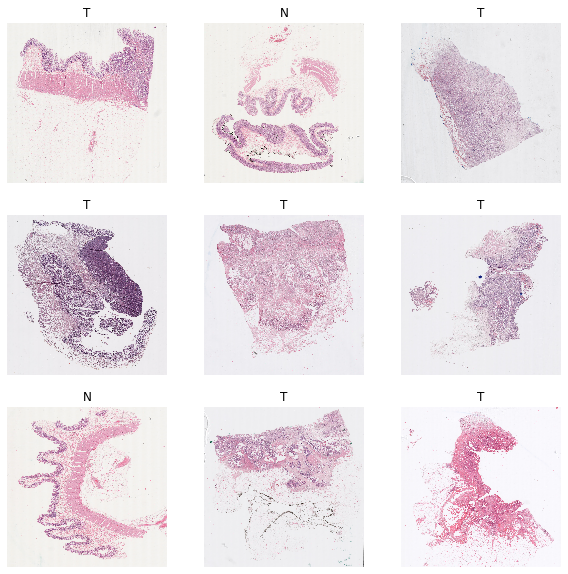

In [87]:
# Printing img examples from dataset

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

    for i in range(9):
        print("Label ", numpy_labels[i], " = ", class_names[numpy_labels[i]])
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.savefig(out_path)


In [110]:
print(numpy_images.shape)
print(numpy_labels.shape)
print(numpy_labels)

(32, 160, 160, 3)
(32,)
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1]


In [14]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 4
Number of test batches: 1


In [15]:
### Configure the dataset for performance

print("\n :: Paso 2. AUTOTUNE\n")

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)



 :: Paso 2. AUTOTUNE



In [16]:
### Use data augmentation

print("\n :: Paso 3. Data augmentation\n")

data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

'''
# Let's repeatedly apply these layers to the same image and see the result.
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
'''


 :: Paso 3. Data augmentation



"\n# Let's repeatedly apply these layers to the same image and see the result.\nfor image, _ in train_dataset.take(1):\n    plt.figure(figsize=(10, 10))\n    first_image = image[0]\n    for i in range(9):\n        ax = plt.subplot(3, 3, i + 1)\n        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))\n        plt.imshow(augmented_image[0] / 255)\n        plt.axis('off')\n"

In [17]:
## Normalization pixel values (-1, 1) - Rescale pixel values

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# Note: Alternatively, you could rescale pixel values from [0,255] to [-1, 1] using a Rescaling layer.
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [18]:
###########################################################
### Create the base model from the pre-trained convnets ###
###########################################################

# First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet.
# By specifying the include_top=False argument, you load a network that doesn't include 
# the classification layers at the top, which is ideal for feature extraction.

print("\n :: Paso 4. Create base model --> weights=imagenet\n")

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
# Original
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')



 :: Paso 4. Create base model --> weights=imagenet



In [19]:
#This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.
# Let's see what it does to an example batch of images:

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [20]:
#Freeze the convolutional base

# It is important to freeze the convolutional base before you compile and train the model.
# Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training.
# MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [21]:
#Add a classification head

# To generate predictions from the block of features, average over the spatial 5x5 spatial locations, 
# using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image.
# You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. 
# Positive numbers predict class 1, negative numbers predict class 0.

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1280)
(32, 1)


In [22]:
# Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API.
# As previously mentioned, use training=False as our model contains a BatchNormalization layer.


inputs = tf.keras.Input(shape=(IMG_SIZE_VAL, IMG_SIZE_VAL, 3))
x = data_augmentation(inputs)
x = preprocess_input(x) # mon :: original
#x = rescale(x) # mon :: preprocess_input(x), provem a veure com queda el rescale
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [23]:
#Once the model is created, you can config the model with losses and metrics with model.compile(), 
# train the model with model.fit(), 
# or use the model to do prediction with model.predict()

#########################
### Compile the model ###
#########################

# Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with from_logits=True 
# since the model provides a linear output.


# optimizer = Adam - https://keras.io/api/optimizers/adam/
#             Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of 
#             first-order and second-order moments.
# loss = BinaryCrossentropy - https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

base_learning_rate = LEARNING_RATE #0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

print("\nlength model = ", len(model.trainable_variables))

# Loss & accuracy from transfer-learning trained model with ImageNet weights
#loss0, accuracy0 = model.evaluate(validation_dataset)
#print("\n\nLoss and accuracy from transfer-learning trained model")
#print("\tInitial loss: ", round(loss0,2))
#print("\tInitial accuracy: ", round(accuracy0, 2))
#print("\n")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [32]:
#######################
### Train the model ###
#######################

# Apply Balance to dataset

#class 0 = 500 samples 
#class 1 = 1500 samples
#class_weight = {0:3 , 1:1}. That gives class 0 three times the weight of class 1.

# 0=N, 1=T
class_weights_computed = {0: 0.6, 1: 0.4}
print("\n :: Paso 5. Balanced weights = ",  class_weights_computed," \n")
              
initial_epochs = EPOCHS #10
print("Add ", initial_epochs, " epochs training\n")

# Add TensorBoard
logdir_TB = TB_DIR + "/TB_HP-" + HYPER_PARAM + "_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir_TB)

print("TB log file: ", logdir_TB)
print("\n")
training_history = model.fit(train_dataset,
                             epochs=initial_epochs,
                             validation_data=validation_dataset,
                             class_weight=class_weights_computed,
                             callbacks=[tensorboard_callback])


print("\nEnd training model\n")

# Para evaluar el training
score = model.evaluate(validation_dataset, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Average test loss: ", np.average(training_history.history['loss']))

# Saving model
model.save(out_path_model_h5)


 :: Paso 5. Balanced weights =  {0: 0.6, 1: 0.4}  

Add  5  epochs training

TB log file:  logs/TensorBoard/TB_HP-0_20210531-111021
Epoch 1/5
30/30 [==============================] - 412s 11s/step - loss: 0.3102 - accuracy: 0.5544 - val_loss: 0.5389 - val_accuracy: 0.7300
Epoch 2/5
30/30 [==============================] - 360s 9s/step - loss: 0.2828 - accuracy: 0.6695 - val_loss: 0.4833 - val_accuracy: 0.7200
Epoch 3/5
30/30 [==============================] - 361s 9s/step - loss: 0.2605 - accuracy: 0.7061 - val_loss: 0.4007 - val_accuracy: 0.8100
Epoch 4/5
30/30 [==============================] - 365s 9s/step - loss: 0.2551 - accuracy: 0.7094 - val_loss: 0.4076 - val_accuracy: 0.7900
Epoch 5/5
30/30 [==============================] - 364s 9s/step - loss: 0.2400 - accuracy: 0.7417 - val_loss: 0.4318 - val_accuracy: 0.7900
Test loss: 0.3927249610424042
Test accuracy: 0.800000011920929
Average test loss:  0.26970760226249696


In [ ]:
###################
### TensorBoard ###
###################

# NO HO PODEM FER DESDEL JUPYTER DIRECTAMENT

# Per poder veure el TensorBoard hem de fer un soft link del directori de logs al directori:
# cd /home/jovyan/board
# ln -s /home/jovyan/work/model/transfer_learning/NAC/model_MobileNet-v2/logs/TensorBoard/TB_HP-NOM TB_HP-NOM


##### Si posem tots els directoris alhora només pot veure el primer #####
# Run on terminal for having the path of TB logs:
# cd /home/jovyan/board
# for i in `ls -d /home/jovyan/work/model/transfer_learning/NAC/model_MobileNet-v2/logs/TensorBoard/*`; do nom=`basename $i`; ln -s $i $nom; done
#########################################################################


In [ ]:
# learning curves of the training and validation accuracy/loss

acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
#plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.savefig(out_path_accuracy)


now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")

print("\n\nDATE:", dt_string, "\n\n")




Labels:       [1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predictions:  [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]




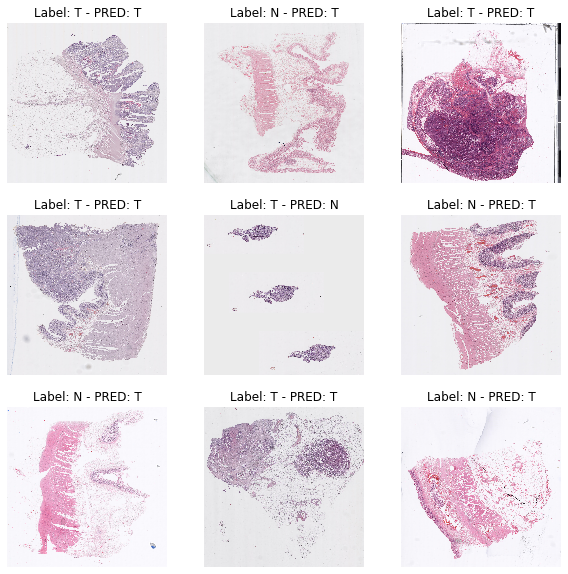

In [168]:
##################
### Prediction ###
##################

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('\n')
print('Labels:      ', label_batch)
print('Predictions: ', predictions.numpy())
print('\n')

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title('Label: '+str(class_names[label_batch[i]])+' - PRED: '+str(class_names[predictions[i]]))
    plt.axis("off")
    plt.savefig(out_path_predicted_img)





Labels:       [1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predictions:  [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 0  4]
 [ 1 27]]




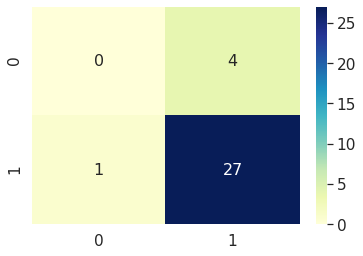

In [180]:
########################
### Confusion Matrix ###
########################

from sklearn.metrics import confusion_matrix

# Albert classe
def plot_confusion_matrix(conf):
    df_cm = pd.DataFrame(conf, range(len(class_names)), range(len(class_names)))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu") # font size
    plt.savefig(out_path_confusion_matrix)

conf = confusion_matrix(label_batch, predictions.numpy())
plot_confusion_matrix(conf)


print('\n')
print('Labels:      ', label_batch)
print('Predictions: ', predictions.numpy())
print('\n')
print(conf)
print('\n')

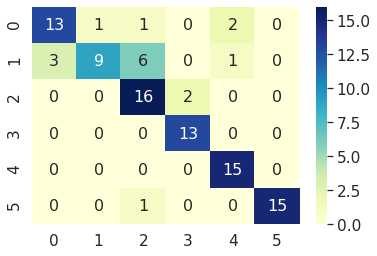

[[13, 1, 1, 0, 2, 0],
 [3, 9, 6, 0, 1, 0],
 [0, 0, 16, 2, 0, 0],
 [0, 0, 0, 13, 0, 0],
 [0, 0, 0, 0, 15, 0],
 [0, 0, 1, 0, 0, 15]]

In [176]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[13,1,1,0,2,0],
         [3,9,6,0,1,0],
         [0,0,16,2,0,0],
         [0,0,0,13,0,0],
         [0,0,0,0,15,0],
         [0,0,1,0,0,15]]

df_cm = pd.DataFrame(array, range(6), range(6))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu") # font size

plt.show()

array